This project is based on the article of Susan Li on towardsdatascience.com for practice purposes
https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

## Problem Formulation

The problem is supervised text classification problem, and our goal is to investigate which supervised machine learning methods are best suited to solve it.

Given a new complaint comes in, we want to assign it to one of 12 categories. The classifier makes the assumption that each new complaint is assigned to one and only one category. This is multi-class text classification problem. I can’t wait to see what we can achieve!

## Data Exploration

We're going to classify Consumer Finance Complaints into 12 pre-defined classes. The data can be downloaded from data.gov.
https://catalog.data.gov/dataset/consumer-complaint-database

Before diving into training machine learning models, we should look at some examples first and the number of complaints in each class:

In [28]:
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
df = pd.read_csv('Consumer_Complaints.csv')
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,03/17/2014,Closed with explanation,Yes,No,759217
1,06/08/2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,06/10/2014,Closed with explanation,Yes,Yes,885638
2,09/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,09/13/2014,Closed with explanation,Yes,Yes,1027760
3,11/13/2013,Mortgage,Conventional adjustable mortgage (ARM),"Loan servicing, payments, escrow account",NaN,NaN,NaN,U.S. BANCORP,MN,48322,NaN,NaN,Phone,11/20/2013,Closed with monetary relief,Yes,No,596562
4,06/16/2015,Debt collection,Medical,Improper contact or sharing of info,Contacted employer after asked not to,NaN,Company believes it acted appropriately as aut...,California Accounts Service,CA,92111,NaN,Consent not provided,Web,06/19/2015,Closed with explanation,Yes,No,1422680


In [30]:
col = ['Product', 'Consumer complaint narrative']
df = df[col]

df = df[pd.notnull(df['Consumer complaint narrative'])]

df.columns = col

df['category_id'] = df['Product'].factorize()[0]

category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')

category_to_id = dict(category_id_df.values)

id_to_category = dict(category_id_df[['category_id', 'Product']].values)

df.head()

,Product,Consumer complaint narrative,category_id
5,Credit reporting,An account on my credit report has a mistaken ...,0
10,Debt collection,This company refuses to provide me verificatio...,1
21,Mortgage,Started the refinance of home mortgage process...,2
22,Mortgage,"In XXXX, I and my ex-husband applied for a ref...",2
23,Credit reporting,I have disputed several accounts on my credit ...,0


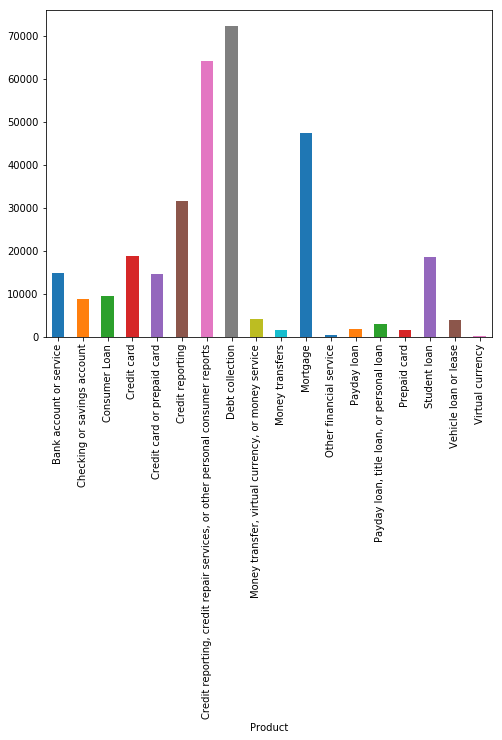

In [31]:
fig = plt.figure(figsize=(8,6))
df.groupby('Product')['Consumer complaint narrative'].count().plot.bar(ylim=0)
plt.show()

### Imbalanced Classes
We see that the number of complaints per product is imbalanced. Consumers’ complaints are more biased towards Debt collection, Credit reporting and Mortgage.

When we encounter such problems, we are bound to have difficulties solving them with standard algorithms. Conventional algorithms are often biased towards the majority class, not taking the data distribution into consideration. In the worst case, minority classes are treated as outliers and ignored. For some cases, such as fraud detection or cancer prediction, we would need to carefully configure our model or artificially balance the dataset, for example by undersampling or oversampling each class.

However, in our case of learning imbalanced data, the majority classes might be of our great interest. It is desirable to have a classifier that gives high prediction accuracy over the majority class, while maintaining reasonable accuracy for the minority classes. Therefore, we will leave it as it is.

## Text Representation
The classifiers and learning algorithms can not directly process the text documents in their original form, as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length. Therefore, during the preprocessing step, the texts are converted to a more manageable representation.

One common approach for extracting features from text is to use the bag of words model: a model where for each document, a complaint narrative in our case, the presence (and often the frequency) of words is taken into consideration, but the order in which they occur is ignored.

Specifically, for each term in our dataset, we will calculate a measure called Term Frequency, Inverse Document Frequency, abbreviated to tf-idf. We will use sklearn.feature_extraction.text.TfidfVectorizer to calculate a tf-idf vector for each of consumer complaint narratives:

In [32]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
#sublinear_df is set to True to use a logarithmic form for frequency.
#min_df is the minimum numbers of documents a word must be present in to be kept.
#norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
#ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.
#stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.


In [33]:
features = tfidf.fit_transform(df['Consumer complaint narrative']).toarray()

MemoryError: 

This project has practice purpose only.
In order to handle memory problem I'll try decreasing the size of data set.(additional memory allocation didn't work)

In [34]:
df = df.sample(3000)

In [35]:
df.shape

(3000, 3)

In [36]:
features = tfidf.fit_transform(df['Consumer complaint narrative']).toarray()

In [37]:
labels = df.category_id
features.shape

(3000, 8426)

Now, each of 3000 consumer complaint narratives is represented by 8426 features, representing the tf-idf score for different unigrams and bigrams.

We can use sklearn.feature_selection.chi2 to find the terms that are the most correlated with each of the products:

In [38]:
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Bank account or service':
  . Most correlated unigrams:
. deposit
. overdraft
  . Most correlated bigrams:
. overdraft fees
. debit card
# 'Checking or savings account':
  . Most correlated unigrams:
. deposited
. deposit
  . Most correlated bigrams:
. checking account
. opened checking
# 'Consumer Loan':
  . Most correlated unigrams:
. repossessed
. vehicle
  . Most correlated bigrams:
. auto loan
. purchased car
# 'Credit card':
  . Most correlated unigrams:
. apr
. card
  . Most correlated bigrams:
. american express
. credit card
# 'Credit card or prepaid card':
  . Most correlated unigrams:
. citi
. card
  . Most correlated bigrams:
. minimum payment
. credit card
# 'Credit reporting':
  . Most correlated unigrams:
. report
. experian
  . Most correlated bigrams:
. unauthorized fraudulent
. information report
# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Most correlated unigrams:
. inquiries
. equifax
  . Most correlated bigrams:
. equifa

## Multi-Class Classifier: Features and Design
To train supervised classifiers, we first transformed the “Consumer complaint narrative” into a vector of numbers. We explored vector representations such as TF-IDF weighted vectors.
After having this vector representations of the text we can train supervised classifiers to train unseen “Consumer complaint narrative” and predict the “product” on which they fall.
After all the above data transformation, now that we have all the features and labels, it is time to train the classifiers. There are a number of algorithms we can use for this type of problem.

### Naive Bayes Classifier:
the one most suitable for word counts is the multinomial variant:

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [52]:
X_train, X_test, y_train, y_test = train_test_split(df['Consumer complaint narrative'], df['Product'], random_state = 0)

In [53]:
count_vect = CountVectorizer()

In [54]:
X_train_counts = count_vect.fit_transform(X_train)

In [55]:
tfidf_transformer = TfidfTransformer()

In [56]:
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [57]:
clf = MultinomialNB().fit(X_train_tfidf, y_train)

After fitting the training set, let’s make some predictions.



In [92]:
print(clf.predict(count_vect.transform(["my name is XXXX XXXX i own the house at XXXX XXXX XXXX XXXX XXXX XXXX XXXX, my mortage company pacific union out of XXXX.well back in XXXX 2014 i received a letter saying that my escow was rasied XXXX. to XXXX a year for hazard insurance but i called my akin insurance and they said that it XXXX a year but pac union is been charging me for XXXX a year i wrote a letter and spoke with pac. union wont chage it and refuse to refund or correct amt.as my pay ment s monthly has gone from XXXX.month to XXXX a month thats XXXX more a year collected my number is XXXX XXXX central time my mortage number isXXXX..i want to take legel action against them for not honest.and over charging me."])))

['Debt collection']


In [91]:
df[df['Consumer complaint narrative'] == "my name is XXXX XXXX i own the house at XXXX XXXX XXXX XXXX XXXX XXXX XXXX, my mortage company pacific union out of XXXX.well back in XXXX 2014 i received a letter saying that my escow was rasied XXXX. to XXXX a year for hazard insurance but i called my akin insurance and they said that it XXXX a year but pac union is been charging me for XXXX a year i wrote a letter and spoke with pac. union wont chage it and refuse to refund or correct amt.as my pay ment s monthly has gone from XXXX.month to XXXX a month thats XXXX more a year collected my number is XXXX XXXX central time my mortage number isXXXX..i want to take legel action against them for not honest.and over charging me."]

,Product,Consumer complaint narrative,category_id
1097358,Mortgage,my name is XXXX XXXX i own the house at XXXX X...,2


In [79]:
print(clf.predict(count_vect.transform(["I received a call from ( XXXX ) XXXX telling me I was being served with papers would I be home. I demanded information from the lady that called and she told me to call Coastline at XXXX, ask for legal department and use reference number XXXX. I looked up the number and determined this is a scam on this website XXXX XXXX I gave them no information and do not plan on calling them back. I was sure this was a scam but now I know that it is."])))

['Debt collection']


In [81]:
df[df['Consumer complaint narrative'] == "I received a call from ( XXXX ) XXXX telling me I was being served with papers would I be home. I demanded information from the lady that called and she told me to call Coastline at XXXX, ask for legal department and use reference number XXXX. I looked up the number and determined this is a scam on this website XXXX XXXX I gave them no information and do not plan on calling them back. I was sure this was a scam but now I know that it is."]

,Product,Consumer complaint narrative,category_id
919586,Debt collection,I received a call from ( XXXX ) XXXX telling m...,1


### Model Selection

We are now ready to experiment with different machine learning models, evaluate their accuracy and find the source of any potential issues.

We will benchmark the following four models:

- Logistic Regression
- (Multinomial) Naive Bayes
- Linear Support Vector Machine
- Random Forest

In [118]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from IPython.display import display
import seaborn as sns

In [94]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

In [95]:
CV = 5

In [96]:
cv_df = pd.DataFrame(index=range(CV * len(models)))

In [97]:
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/home/muzo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/muzo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/muzo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/muzo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, 

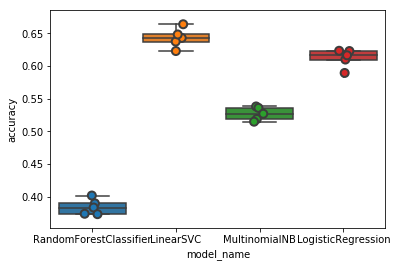

In [99]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [100]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.643082
LogisticRegression        0.612394
MultinomialNB             0.527031
RandomForestClassifier    0.384707
Name: accuracy, dtype: float64

LinearSVC and Logistic Regression perform better than the other two classifiers, with LinearSVC having a slight advantage with a median accuracy of around 82%.

## Model Evaluation
Continue with our best model (LinearSVC), we are going to look at the confusion matrix, and show the discrepancies between predicted and actual labels.

In [101]:
model = LinearSVC()

In [102]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)

In [103]:
model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [104]:
y_pred = model.predict(X_test)

In [106]:
conf_mat = confusion_matrix(y_test, y_pred)

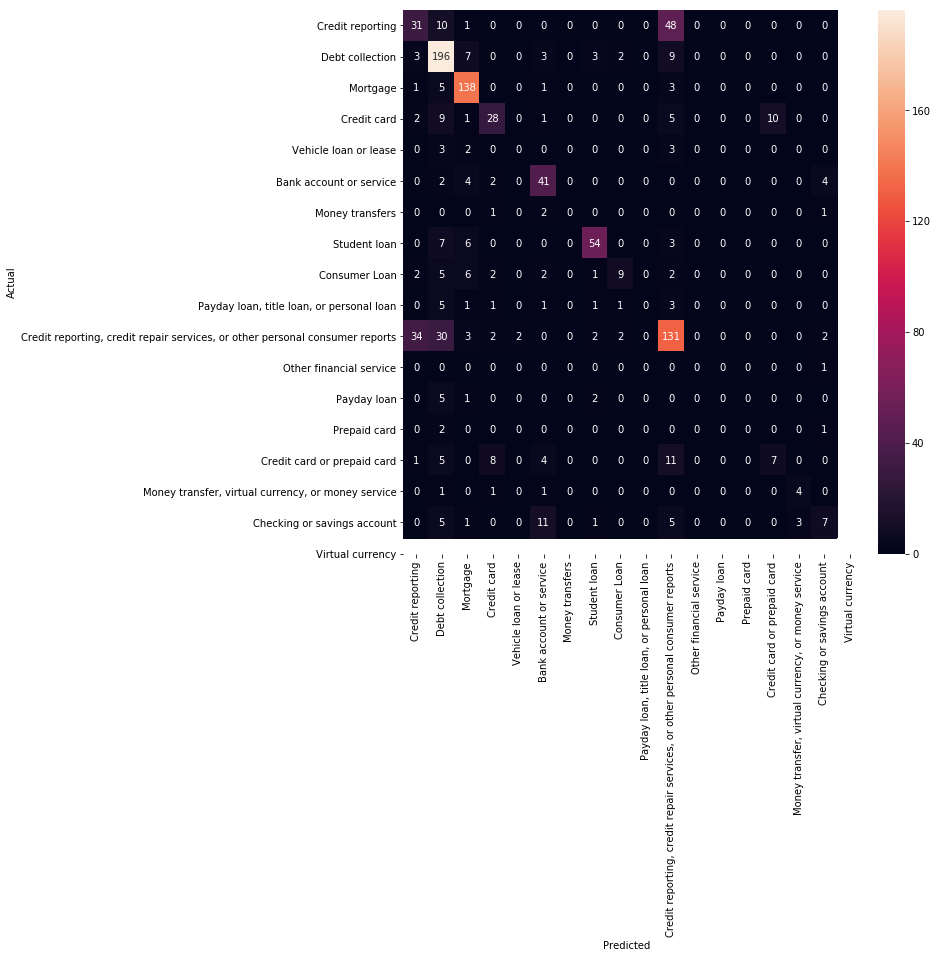

In [108]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The vast majority of the predictions end up on the diagonal (predicted label = actual label), where we want them to be. However, there are a number of misclassifications, and it might be interesting to see what those are caused by:

In [114]:
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer complaint narrative']])
      print('')

'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit reporting' : 34 examples.


,Product,Consumer complaint narrative
858433,"Credit reporting, credit repair services, or o...",I was advised to contact you all regarding ite...
663834,"Credit reporting, credit repair services, or o...",My father & I went to XXXX in order to move my...
818693,"Credit reporting, credit repair services, or o...",XXXX Inquiry from XX/XX/2016 + Finance i never...
639026,"Credit reporting, credit repair services, or o...",I have tried numerous times to have the correc...
710290,"Credit reporting, credit repair services, or o...",In XXXX 2017 I went to the Experian Credit Rep...
1045413,"Credit reporting, credit repair services, or o...",I reported identity theft and the accounts wer...
928023,"Credit reporting, credit repair services, or o...",I am very frustrated with all 3 reporting comp...
946782,"Credit reporting, credit repair services, or o...","XXXX XXXX XXXX, The firSt one is XXXX XXXX {$4..."
843495,"Credit reporting, credit repair services, or o...",Applied for a car loan and was given an intere...
669723,"Credit reporting, credit repair services, or o...",I filed a complaint with Transunion on XX/XX/X...


IndexError: index 17 is out of bounds for axis 0 with size 17

As you can see, some of the misclassified complaints are complaints that touch on more than one subjects (for example, complaints involving both credit card and credit report). This sort of errors will always happen.

Again, we use the chi-squared test to find the terms that are the most correlated with each of the categories:

In [115]:
model.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [116]:
N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Bank account or service':
  . Top unigrams:
       . bank
       . debit
  . Top bigrams:
       . debit card
       . bank card
# 'Checking or savings account':
  . Top unigrams:
       . bank
       . transaction
  . Top bigrams:
       . stop payment
       . check xxxx
# 'Consumer Loan':
  . Top unigrams:
       . vehicle
       . loan
  . Top bigrams:
       . auto loan
       . paid account
# 'Credit card':
  . Top unigrams:
       . card
       . apr
  . Top bigrams:
       . collection calls
       . new card
# 'Credit card or prepaid card':
  . Top unigrams:
       . card
       . citi
  . Top bigrams:
       . minimum payment
       . credit card
# 'Credit reporting':
  . Top unigrams:
       . experian
       . equifax
  . Top bigrams:
       . xxxx bureaus
       . unauthorized fraudulent
# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Top unigrams:
       . credit
       . equifax
  . Top bigrams:
       . sent dispute
       . xxxx

IndexError: index 17 is out of bounds for axis 0 with size 17

They are consistent within our expectation.



Finally, we print out the classification report for each class:



In [119]:
print(metrics.classification_report(y_test, y_pred, target_names=df['Product'].unique()))


                                                                              precision    recall  f1-score   support

                                                               Consumer Loan       0.42      0.34      0.38        90
                                                                    Mortgage       0.68      0.88      0.76       223
                                                                Student loan       0.81      0.93      0.87       148
                                                             Debt collection       0.62      0.50      0.55        56
Credit reporting, credit repair services, or other personal consumer reports       0.00      0.00      0.00         8
                                                     Bank account or service       0.61      0.77      0.68        53
                          Money transfer, virtual currency, or money service       0.00      0.00      0.00         4
                                                       

/home/muzo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
